In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func 

In [38]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [40]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [43]:
# Find the most recent date in the data set.
mostrecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
mostrecent

('2017-08-23')

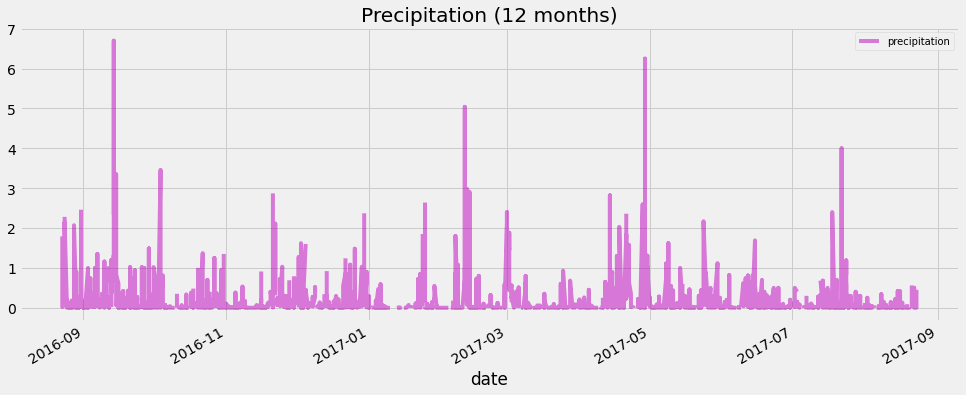

In [50]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_year_precip = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#find date 12 months before
prior_year = dt.datetime.strptime(last_year_precip, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
data_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prior_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(data_query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date column
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

precipitation_df.head(30)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (12 months)", color='m', alpha=0.5, figsize=(15,6))
plt.legend(prop={'size': 10})

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [46]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"This dataset contains {station_count} unique stations.")

This dataset contains 9 unique stations.


In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Station.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station
.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
most_active_station_df = pd.DataFrame(station_count, columns = ["Station ID","Station Name","Activity Count"])

most_active_station_df

,Station ID,Station Name,Activity Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs_id_selected = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs), func.count(Measurement.tobs)]
temps = session.query(*tobs_id_selected).\
    filter(Measurement.station == 'USC00519281')
    
for rec in temps:
    print(f"For Station USC00519281:")
    print(f"Min Temprature is: {rec[0]}")
    print(f"Max Temprature is: {rec[1]}")
    print(f"Average Temprature is: {round(rec[2], 1)}")

For Station USC00519281:
Min Temprature is: 54.0
Max Temprature is: 85.0
Average Temprature is: 71.7


Text(0.5, 0, 'Temperature (F)')

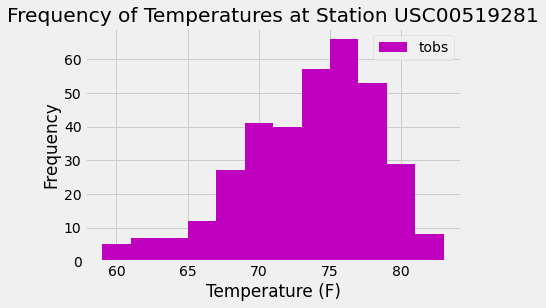

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_id_temp = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.date >= prior_year).\
        filter(Measurement.station == 'USC00519281').\
            order_by(Measurement.date.asc()).\
                all()

# turn query into a dataframe

active_id_temp_df = pd.DataFrame(active_id_temp).set_index('date').sort_index(ascending=True)

# plot the dataframe

active_id_temp_df.plot(kind='hist',bins=12,color = "m")
plt.title(f"Frequency of Temperatures at Station USC00519281")
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')

# Close session

In [34]:
# Close Session
session.close()